In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob
import sys

import util_tr_new as tr
from scipy import interpolate  # , signal
from scipy.signal import savgol_filter

datadir = Path("/Users/uedataiga/Desktop/grad-research/data_analysis/Data/PPMS/240117_#1-1398(2-1)_100um")
sample = "1398"
if not os.path.exists(datadir / sample):
    os.mkdir(datadir / sample)
savedir = datadir / sample

thickness = 20e-9  # m = 20 nm
width = 100e-6  # m = 20 um
e = 1.602e-19  # C
current_float = 250e-6  # float(key[-5:-1])

# Rxx2omegaの最大の値を計算するためのBの位置
B_Rxx2omega, thresh_Rxx2omega = 2, 0.1
# gammaを計算するためのBの位置
B_gamma, thresh_gamma = 1, 0.1


# RT

header: ['Time (min)', 'Temperature (K)', 'Field (Oe)', 'Position (deg)', 'Lock-in1(X)', 'Lock-in1(Y)', 'Lock-in2(X)', 'Lock-in2(Y)', 'Current(X)', 'Current(Y)']
current=  0.00025


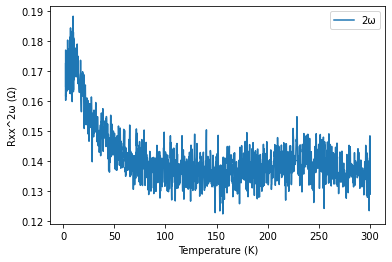

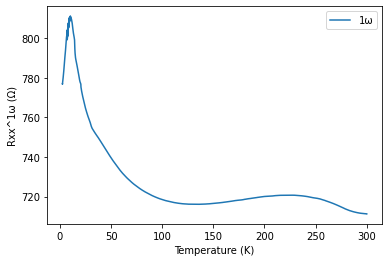

RT.csv saved


In [16]:
# RT
df_dict = {}
# for filename in sorted(glob(str(datadir / "3_14T_sweep_*e-*A.txt"))):
filename = str(datadir / "1_RT.txt")
key = Path(filename).stem

with open(filename, "r") as f:
    df = []
    i = 0
    while True:
        line = f.readline().strip()
        if not line:
            break
        elif i == 0:
            header = line.split("\t")
            print(f"header: {header}")
        else:
            df.append([float(x) for x in line.split("\t")])
        i += 1
df = pd.DataFrame(df, columns=header)
# df_dict[Path(filename).stem] = df
df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
df.to_csv(savedir / ("raw_RT.csv"), index=False)

B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
# fixed_temp = df["Temperature (K)"].mean()
temp = df["Temperature (K)"].values
Vxx2omega_raw = df["Lock-in2(Y)"].values
Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意

print("current= ", current_float)
Rxx2omega = Vxx2omega_raw / current_float
Rxx1omega = Vxx1omega_raw / current_float
current = np.full_like(temp, current_float)
plt.plot(temp, Rxx2omega, label="2ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^2ω (Ω)")
plt.legend()
plt.show()
plt.plot(temp, Rxx1omega, label="1ω")
plt.xlabel("Temperature (K)")
plt.ylabel("Rxx^1ω (Ω)")
plt.legend()
plt.show()

Gxx1omega = savgol_filter(current_float / Vxx1omega_raw,  21, 3) # Ω^-1
Gxx2omega = savgol_filter(-2*Vxx2omega_raw / (Vxx1omega_raw)**2,  21, 3) # （ΩA)^-1

new_df = pd.DataFrame({
    "temp": temp, "current": current, "B": B_raw, 
    "Vxx2omega": Vxx2omega_raw, "Vxx1omega": Vxx1omega_raw, 
    "Gxx2omega": Gxx2omega, "Gxx1omega": Gxx1omega,
    "Rxx2omega": Rxx2omega, "Rxx1omega": Rxx1omega})
new_df.to_csv(savedir / "RT.csv", index=False)
print("RT" + ".csv saved")

In [17]:

# # temp_dep
# df_dict = {}
# for filename in sorted(glob(str(datadir / "1_2T_sweep_250uA.txt"))):
#     print(Path(filename).stem)
#     with open(filename, "r") as f:
#         df = []
#         i = 0
#         while True:
#             line = f.readline().strip()
#             if not line:
#                 break
#             elif i == 0:
#                 header = line.split("\t")
#             else:
#                 df.append([float(x) for x in line.split("\t")])
#             i += 1
#     df = pd.DataFrame(df, columns=header)
#     df_dict[Path(filename).stem] = df


# # Lock-in2(Y)のみのデータを抽出
# # それをI^2で割った値を新たなカラムに追加
# # 反対称化
# # csv保存
# Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
# for key in df_dict.keys():
#     print(f"------------------{key}------------------")
#     df = df_dict[key]
#     df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
#     df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

#     B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
#     fixed_temp = df["Temperature (K)"].mean()
#     temps.append(fixed_temp)

#     Vxx2omega_raw = df["Lock-in2(Y)"].values
#     # V1omega_raw = df["Lock-in1(Y)"].values
#     Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
#     print(len(Vxx2omega_raw))
#     print(len(B_raw))
#     B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))
#     print(len(Vxx2omega_u))
#     B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))
#     # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

#     # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
#     # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
#     temp = np.full_like(B_ref_u, fixed_temp)

#     Rxx2omega_u = Vxx2omega_u / current_float
#     Rxx2omega_d = Vxx2omega_d / current_float
#     Rxx1omega_u = Vxx1omega_u / current_float
#     Rxx1omega_d = Vxx1omega_d / current_float
#     print(len(Rxx2omega_d))
#     Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
#     Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
#     Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
#     Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)
#     plt.plot(B_ref_d, Rxx2omega_d, label="raw")
#     plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
#     plt.legend()
#     plt.show()
#     plt.plot(B_ref_d, Rxx1omega_u, label="raw")
#     plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
#     plt.legend()
#     plt.show()
#     current = np.full_like(B_ref_u, current_float)

#     # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
#     idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
#     print(idx_lowB, B_ref_d[idx_lowB])
#     # Rxx_3T_mean = np.mean(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
#     # Rxx_3T_std = np.std(Rxx2omega_d_smooth[idx_3T - 10 : idx_3T + 10])
#     Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
#     Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
#     Rxx_lowB_means.append(Rxx_lowB_mean)
#     Rxx_lowB_stds.append(Rxx_lowB_std)
#     currents.append(current_float)

#     idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
#     idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
#     DeltaR = (Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n])
#     DeltaB = (B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n])
#     # print("DeltaR = ", DeltaR)
#     # print("B: ", B_ref_d[idx_lowB_p], B_ref_d[idx_lowB_n])
#     # print("Rxx2omega: ", Rxx2omega_d_smooth[idx_lowB_p], Rxx2omega_d_smooth[idx_lowB_n])
#     current_density = current_float / (width * thickness)  # A/m^2
#     # print("current_density = ", current_density)
#     # R0 = 0.041106 / current_float  # Ω
#     # Rxx1omegaの最大値をR0とする
#     R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
#     print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])


#     gamma = 2*(DeltaR/DeltaB) / (current_density * R0)
#     print("gamma = ", gamma)
#     gammas.append(gamma)
#     R0s.append(R0)

#     Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
#     Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
#     Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
#     Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)
#     plt.plot(B_ref_d, Gxx2omega_d)
#     plt.plot(B_ref_u, Gxx2omega_u)
#     plt.xlabel("B (T)")
#     plt.ylabel(r"Gxx2omega ($\Omega^{-1}$)")
#     plt.show()
#     plt.plot(B_ref_d, Gxx1omega_d)
#     plt.plot(B_ref_u, Gxx1omega_u)
#     plt.xlabel("B (T)")
#     plt.ylabel(r"Gxx1omega ($\Omega^{-1}$)")
#     plt.show()

#     Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
#     Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)
#     new_df = pd.DataFrame({
#         "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
#         "Vxx2omega_u": Vxx2omega_u, "V2omega_d": Vxx2omega_d, "Vxx1omega_d": Vxx1omega_d, "Vxx1omega_u": Vxx1omega_u, 
#         "Rxx2omega_u": Rxx2omega_u_smooth, "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
#         "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
#         "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})

# temp dep

1_9T_sweep_250uA_2K
------------------1_9T_sweep_250uA_2K------------------


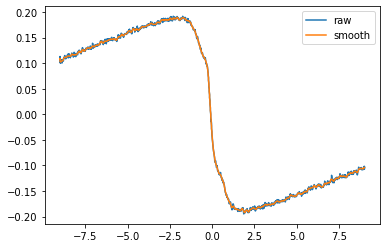

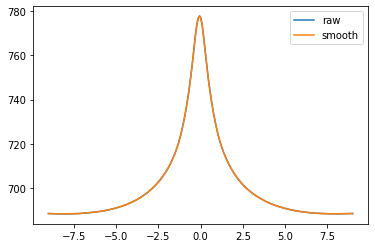

(array([624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
       637, 638, 639, 640, 641]),)
624 2.08838
R0 =  777.6628386020558 , B =  -0.0629214
gamma =  -3.3749711921881798e-12


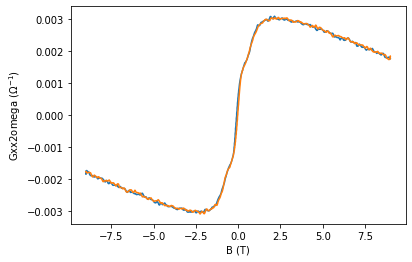

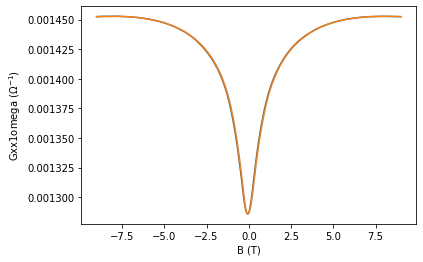

1_9T_sweep_250uA_2K.csv saved
Rxx_2T_250uA_100um_T_dep.csv saved
[2.449992594822396]


In [18]:
df_gamma_name = f"gamma_{B_gamma}T_250uA_100um_T_dep.csv"
summary_name = f"Rxx_{B_Rxx2omega}T_250uA_100um_T_dep.csv"


# temp_dep
df_dict = {}
for filename in sorted(glob(str(datadir / "1_9T_sweep_250uA_*K.txt"))):
    print(Path(filename).stem)
    with open(filename, "r") as f:
        df = []
        i = 0
        while True:
            line = f.readline().strip()
            if not line:
                break
            elif i == 0:
                header = line.split("\t")
            else:
                df.append([float(x) for x in line.split("\t")])
            i += 1
    df = pd.DataFrame(df, columns=header)
    df_dict[Path(filename).stem] = df


# Lock-in2(Y)のみのデータを抽出
# それをI^2で割った値を新たなカラムに追加
# 反対称化
# csv保存
Rxx_lowB_means, Rxx_lowB_stds, currents, gammas, temps, R0s = [], [], [], [], [], []
for key in df_dict.keys():
    print(f"------------------{key}------------------")
    df = df_dict[key]
    df = df[["Temperature (K)", "Field (Oe)", "Lock-in1(X)", "Lock-in1(Y)", "Lock-in2(X)", "Lock-in2(Y)"]]
    df.to_csv(savedir / ("raw_" + key + ".csv"), index=False)

    B_raw = df["Field (Oe)"].values * 1e-4  # Oe -> T
    fixed_temp = df["Temperature (K)"].mean()
    temps.append(fixed_temp)

    Vxx2omega_raw = df["Lock-in2(Y)"].values
    # V1omega_raw = df["Lock-in1(Y)"].values
    Vxx1omega_raw = -df["Lock-in1(X)"].values  # 位相180°回転に注意
    B_ref_u, _, Vxx2omega_u, B_ref_d, _, Vxx2omega_d = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx2omega_raw))
    B_ref_u, Vxx1omega_u, _, B_ref_d, Vxx1omega_d, _ = tr.symmetrize(*tr.split_up_down_scans(B_raw, Vxx1omega_raw))
    # (x_ref_u, y_sym_u, y_asym_u, x_ref_d, y_sym_d, y_asym_d)

    # V2omega_d_int = interpolate.interp1d(B_ref_d, V2omega_d)
    # V2omega_u_int = interpolate.interp1d(B_ref_u, V2omega_u)
    temp = np.full_like(B_ref_u, fixed_temp)

    Rxx2omega_u = Vxx2omega_u / current_float
    Rxx2omega_d = Vxx2omega_d / current_float
    Rxx1omega_u = Vxx1omega_u / current_float
    Rxx1omega_d = Vxx1omega_d / current_float
    Rxx2omega_d_smooth = savgol_filter(Rxx2omega_d, 21, 3)
    Rxx2omega_u_smooth = savgol_filter(Rxx2omega_u, 21, 3)
    Rxx1omega_d_smooth = savgol_filter(Rxx1omega_d, 21, 3)
    Rxx1omega_u_smooth = savgol_filter(Rxx1omega_u, 21, 3)

    plt.plot(B_ref_d, Rxx2omega_d, label="raw")
    plt.plot(B_ref_d, Rxx2omega_d_smooth, label="smooth")
    plt.legend()
    plt.show()
    plt.plot(B_ref_d, Rxx1omega_u, label="raw")
    plt.plot(B_ref_d, Rxx1omega_u_smooth, label="smooth")
    plt.legend()
    plt.show()
    current = np.full_like(B_ref_u, current_float)

    # Rxx2omega_dの3T前後の20点の平均，標準偏差を計算
    print(np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega))
    idx_lowB = np.where(np.abs(np.array(B_ref_d) - B_Rxx2omega) < thresh_Rxx2omega)[0][0]
    print(idx_lowB, B_ref_d[idx_lowB])
    Rxx_lowB_mean = np.mean(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_std = np.std(Rxx2omega_d_smooth[idx_lowB - 10 : idx_lowB + 10])
    Rxx_lowB_means.append(Rxx_lowB_mean)
    Rxx_lowB_stds.append(Rxx_lowB_std)
    currents.append(current_float)

    idx_lowB_p = np.where(np.abs(np.array(B_ref_d) - B_gamma) < thresh_gamma)[0][0]
    idx_lowB_n = np.where(np.abs(np.array(B_ref_d) + B_gamma) < thresh_gamma)[0][0]
    DeltaR = Rxx2omega_d_smooth[idx_lowB_p] - Rxx2omega_d_smooth[idx_lowB_n]
    DeltaB = B_ref_d[idx_lowB_p] - B_ref_d[idx_lowB_n]
    current_density = current_float / (width * thickness)  # A/m^2
    # Rxx1omegaの最大値をR0とする
    R0 = Rxx1omega_d_smooth[np.argmax(Rxx1omega_d_smooth)]
    print("R0 = ", R0, ", B = ", B_ref_d[np.argmax(Rxx1omega_d_smooth)])


    gamma = 2*(DeltaR / DeltaB) / (current_density * R0)
    print("gamma = ", gamma)
    gammas.append(gamma)
    R0s.append(R0)

    Gxx1omega_d = savgol_filter(current_float / Vxx1omega_d,  21, 3)
    Gxx1omega_u = savgol_filter(current_float / Vxx1omega_u,  21, 3)
    Gxx2omega_d = savgol_filter(-2*Vxx2omega_d / (Vxx1omega_d)**2,  21, 3)
    Gxx2omega_u = savgol_filter(-2*Vxx2omega_u / (Vxx1omega_u)**2,  21, 3)
    plt.plot(B_ref_d, Gxx2omega_d)
    plt.plot(B_ref_u, Gxx2omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx2omega ($\Omega^{-1}$)")
    plt.show()
    plt.plot(B_ref_d, Gxx1omega_d)
    plt.plot(B_ref_u, Gxx1omega_u)
    plt.xlabel("B (T)")
    plt.ylabel(r"Gxx1omega ($\Omega^{-1}$)")
    plt.show()

    Rxx2omega_d_over_R0_B = 2*Rxx2omega_d_smooth / (R0 * current_density)
    Rxx2omega_u_over_R0_B = 2*Rxx2omega_u_smooth / (R0 * current_density)

    new_df = pd.DataFrame({
        "temp": temp, "current": current, "B_ref_d": B_ref_d, "B_ref_u": B_ref_u, 
        "Vxx2omega_u": Vxx2omega_u, "Vxx2omega_d": Vxx2omega_d, "Vxx1omega_d": Vxx1omega_d, "Vxx1omega_u": Vxx1omega_u, "Rxx2omega_u": Rxx2omega_u_smooth, 
        "Rxx2omega_d": Rxx2omega_d_smooth, "Rxx1omega_u": Rxx1omega_u_smooth, "Rxx1omega_d": Rxx1omega_d_smooth, 
        "Gxx2omega_u": Gxx2omega_u, "Gxx2omega_d": Gxx2omega_d, "Gxx1omega_u": Gxx1omega_u, "Gxx1omega_d": Gxx1omega_d,
        "Rxx2omega_d_over_R0_B": Rxx2omega_d_over_R0_B, "Rxx2omega_u_over_R0_B": Rxx2omega_u_over_R0_B})
    new_df.to_csv(savedir / (key + ".csv"), index=False)
    print(key + ".csv saved")

sort_idx = np.argsort(np.array(temps))
currents_summary, temps_summary, Rxx_lowB_means_summary, Rxx_lowB_stds_summary = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(Rxx_lowB_means)[sort_idx], np.array(Rxx_lowB_stds)[sort_idx]
df_summary = pd.DataFrame({"current": currents_summary, "temp": temps_summary, "Rxx_lowB_mean": Rxx_lowB_means_summary, "Rxx_lowB_std": Rxx_lowB_stds_summary})
df_summary.to_csv(savedir / summary_name, index=False)
print(f"{summary_name} saved")

sort_idx = np.argsort(np.array(temps))
currents_gamma, temps_gamma, gammas_gamma, R0s_gamma = np.array(currents)[sort_idx], np.array(temps)[sort_idx], np.array(gammas)[sort_idx], np.array(R0s)[sort_idx]
print(temps)
df_gamma = pd.DataFrame({"current": currents_gamma, "temp": temps_gamma, "gamma": gammas_gamma, "R0": R0s_gamma})
df_gamma.to_csv(savedir / df_gamma_name, index=False)